## Notebook Generated using Apocrita OnDemand

Hudak et al., (2018). Open OnDemand: A web-based client portal for HPC centers. Journal of Open Source Software, 3(25), 622, https://doi.org/10.21105/joss.00622

In [1]:
pwd

'/data/home/bt211037/dissertation'

In [1]:
# Imports
import pandas as pd # dataframes
import matplotlib.pyplot as plt # plots
import seaborn as sns # plots
import missingno as msno # Missing values
import numpy as np # arrays
import math # math.ceil
from dython.nominal import associations # correlation anal
from timeit import default_timer as timer # Time how long commands take

import warnings # Control warnings
warnings.filterwarnings('ignore') # Ignore warnings to clean up visual output change back to 'default' to see them

%matplotlib inline
plt.style.use('ggplot')

# Get dataframe

In [3]:
# Read in phenotype dataframe
df = pd.read_csv('/data/home/bt211037/dissertation/input/raw_data/FINAL_25.tab', sep='\t', header=0, index_col=0)

In [4]:
# Read in disease dataframe to extract thyroid cancer column
diseases_df = pd.read_csv('/data/home/bt211037/dissertation/input/raw_data/phecodes_clean_2021.txt', sep='\t', header=0, index_col=0)

In [5]:
# Add thyroid cancer column to phenotype df
df['thyroid_cancer']=diseases_df['p193']

In [6]:
# Remove rows with missing thyroid cancer values
df=df.loc[df['thyroid_cancer'].notnull()]

# Convert phenotype codes to descriptions

In [7]:

# Function for converting phecodes to descriptions. Works when descriptions/phecodes are the headers.
def phecode_header_conversion(data, dictionary_df, key_col, new_col, index_col=False):

    dataframe = data # re-assign dataframe
    colnames = list(dataframe.columns)  # Create a list of phecodes in existing df
    new = []  # New column entries - descriptions

    for item in colnames:  # Iterate over phecodes
        # Iterate over dictionary df keys (phecodes) and values (descriptions)
        for key, value in zip(list(dictionary_df[key_col]), list(dictionary_df[new_col])):
            if item == key:  # If phecode in current df
                new.append(value)  # Add corresponding description to new list
            else:  # If not pass
                pass

    dataframe.set_axis(new, 1, inplace=True)   # Replace headers with descriptions

    return dataframe  # Return new dataframe

In [8]:
# Read in data containg phenotype descriptions
dictionary_df = pd.read_csv('/data/home/bt211037/dissertation/input/raw_data/ukbb_and_phec_clean.txt', sep='\t', header=0)

In [9]:
# Check if all column headers are in dictionary 
cols = list(df.columns) # Create list of column names in our data
col_translations = list(dictionary_df['FieldID']) # List of possible columns names in dictionary 

not_included = set(cols) - set(col_translations) # Find values in columns headers not in dictionary
not_included

{'medication_cbi',
 'thyroid_cancer',
 'x22009_0_16',
 'x22009_0_17',
 'x22009_0_18',
 'x22009_0_19',
 'x22009_0_20',
 'x22009_0_21',
 'x22009_0_22',
 'x22009_0_23',
 'x22009_0_24',
 'x22009_0_25',
 'x22009_0_26',
 'x22009_0_27',
 'x22009_0_28',
 'x22009_0_29',
 'x22009_0_30',
 'x22009_0_31',
 'x22009_0_32',
 'x22009_0_33',
 'x22009_0_34',
 'x22009_0_35',
 'x22009_0_36',
 'x22009_0_37',
 'x22009_0_38',
 'x22009_0_39',
 'x22009_0_40'}

- Thyroid cancer and medications cbi do not need to be translated as they are already descriptive.
- The other variants are the genetic principle components from 16-40. Discovered by searching for 22009 in the Biobank  [data showcase](https://biobank.ndph.ox.ac.uk/showcase/field.cgi?id=22009).
- Clearly, genetic principle compnents 1-16 have been included but the others have been missed and need to be added.

In [10]:
# Determine how existing genetics principle components are described
dictionary_df.loc[dictionary_df['FieldID'] == 'x22009_0_15']

,FieldID,Field
1349,x22009_0_15,Genetic principal components_15|x22009_0_15


In [11]:
# Add the missing genetic principle components
for item in not_included:
    if item == 'medication_cbi' or item == 'thyroid_cancer': # Add these as they are for simplicity 
        dictionary_df.loc[len(dictionary_df.index)] = [item, item] 
    else:
        dictionary_df.loc[len(dictionary_df.index)] = [item, f'Genetic principal components_{item[-2:]}|{item}'] 

In [12]:
# Check all items have been added 
cols2 = list(df.columns) # Create list of column names in our data
col_translations2 = list(dictionary_df['FieldID']) # List of possible columns names in dictionary 
not_included2 = set(cols2) - set(col_translations2)
len(not_included2)

0

In [13]:
# Manually check new entries to dicitonary are there
dictionary_df.tail(30)

,FieldID,Field
10339,m2038460068,phenobarbitone|m2038460068
10340,m2038460076,phenytoin|m2038460076
10341,m2038460150,paracetamol|m2038460150
10342,x22009_0_23,Genetic principal components_23|x22009_0_23
10343,x22009_0_25,Genetic principal components_25|x22009_0_25
10344,x22009_0_27,Genetic principal components_27|x22009_0_27
10345,x22009_0_22,Genetic principal components_22|x22009_0_22
10346,x22009_0_16,Genetic principal components_16|x22009_0_16
10347,x22009_0_39,Genetic principal components_39|x22009_0_39
10348,x22009_0_17,Genetic principal components_17|x22009_0_17


In [14]:
# Convert the dataframe headers
df = phecode_header_conversion(df, dictionary_df, 'FieldID', 'Field' )

# Missing Values

<AxesSubplot:>

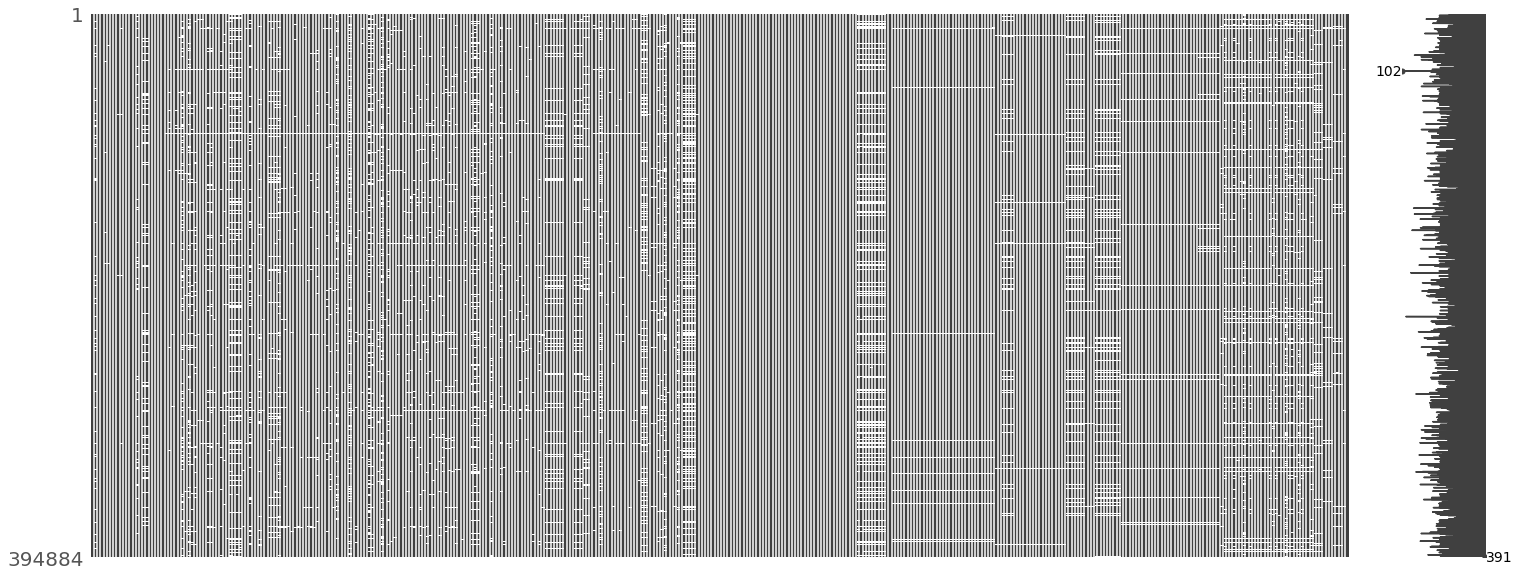

In [15]:
# Matrix plot giving positional information about missing values
msno.matrix(df)

# Target-Class Imbalance

In [16]:
# Create a dataframe showing thyroid cancer vs no thyroid cancer to plot from
c_imbal = pd.DataFrame([[len(df.loc[df['thyroid_cancer'] == 1]), 'Thyroid_Cancer'], [len(df.loc[df['thyroid_cancer'] != 1]), 'No_Thyroid_Cancer']], columns=['Participant_Count', 'Disease_State'])
c_imbal

,Participant_Count,Disease_State
0,686,Thyroid_Cancer
1,394198,No_Thyroid_Cancer


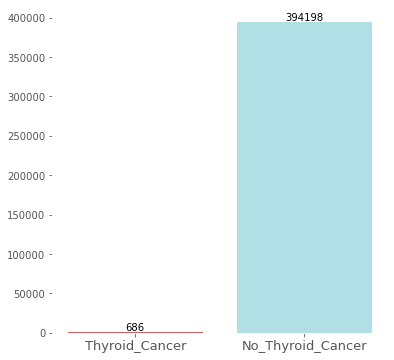

In [17]:
# Plot bar chart of imbalance
colours = ['indianred', 'powderblue'] # Colour names
plt.figure(figsize=(6,6)) # Figure size
plt.rcParams['axes.facecolor'] = 'white' # Barchart background colour
plt.grid() # Remove grid background

bars = plt.bar(c_imbal['Disease_State'], c_imbal['Participant_Count'], color=colours) # Create the bars
plt.bar_label(bars) # Add number label on top of bars
plt.xticks(fontsize=13) # Fontsize of x-axis bar labels

#plt.savefig('class_imbalance_bar.png', bbox_inches='tight') # Save figure
plt.show() # Show figure


# Summary Statistics

In [18]:
# Function to get column names for continuous and non-continuous (categorical) features
def find_cat_or_con_columns(dataframe):

    columns = [list(dataframe[i]) for i in dataframe] # Nested list of column values

    uniques = [len(set([i for i in a if pd.notna(i)])) for a in columns] # Num of unique values in a column

    continuous_indexes = [i for i, c in enumerate(uniques) if c > 50] # Indexes of continuous columns

    categorical_indexes = [i for i, c in enumerate(uniques) if c <= 50] # Indexes of categorical columns

    con_cols = [dataframe.columns[x] for x in continuous_indexes] # List containing continuous columns names

    cat_cols = [dataframe.columns[x] for x in categorical_indexes] # List containing categorical columns names

    return con_cols, cat_cols # return two lists of continuous & categorical column names

In [19]:
# Find continuous columns
continuous_cols, categorical_cols = find_cat_or_con_columns(df)

# Number of continuous cols
num_con = len(continuous_cols)

# Summary statistics for continuous columns (transpose for presentation)
con_summary = df[continuous_cols].groupby(df['thyroid_cancer']).describe().T

print(num_con)
print()
con_summary.head(20)

226



thyroid_cancer                                      0.0         1.0
Hand grip strength (left)|x46_0_0  count  392232.000000  681.000000
                                   mean       29.383077   26.311307
                                   std        11.311568   11.034305
                                   min         0.000000    0.000000
                                   25%        21.000000   19.000000
                                   50%        28.000000   24.000000
                                   75%        38.000000   32.000000
                                   max        89.000000   66.000000
Hand grip strength (right)|x47_0_0 count  392300.000000  681.000000
                                   mean       31.506447   28.629956
                                   std        11.261461   10.838707
                                   min         0.000000    1.000000
                                   25%        23.000000   20.000000
                                   50%        30.000000   28.000000
                                   75%        40.000000   34.000000
                                   max        90.000000   72.000000
Waist circumference|x48_0_0        count  393268.000000  684.000000
                                   mean       90.693881   90.827047
                                   std        13.549167   14.388987
                                   min        20.000000   57.000000

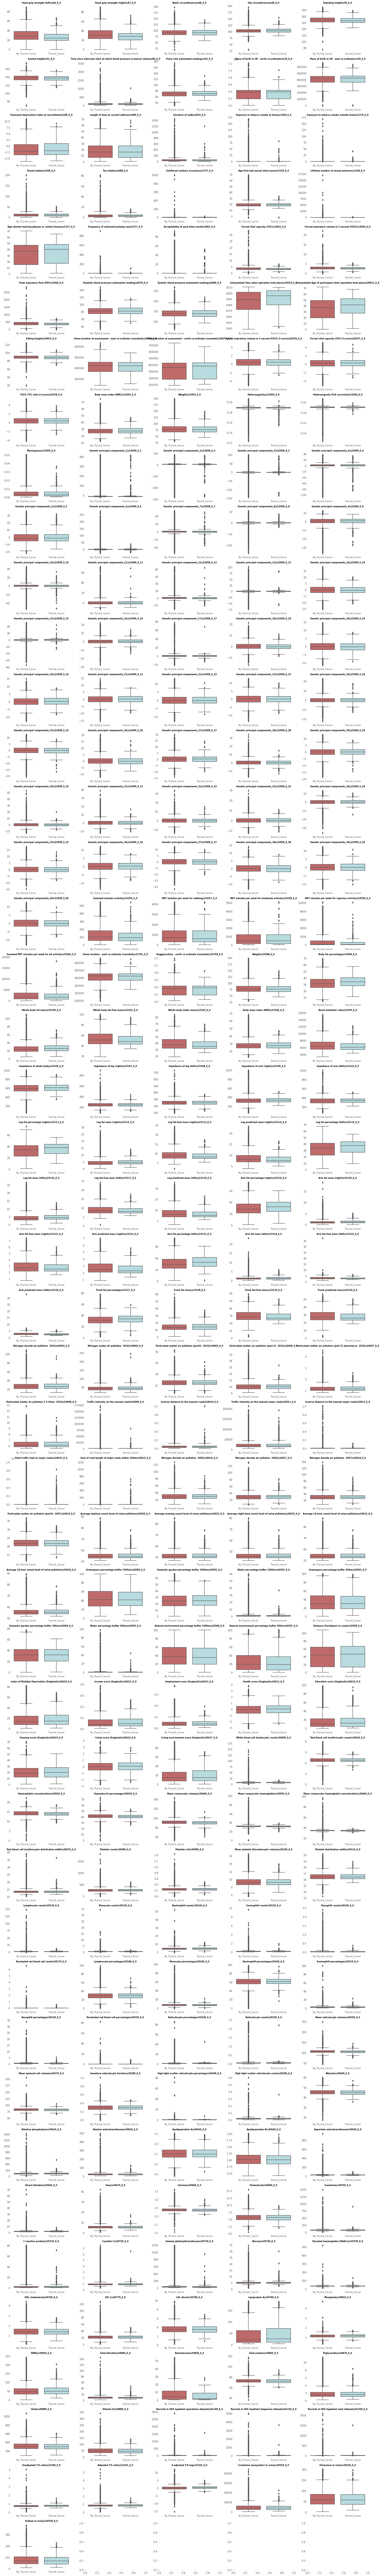

In [20]:
### Boxplots ###
# For continuous columns
customPalette = sns.set_palette(sns.color_palette(colours))

fig_col_num = 5
fig_row_num = math.ceil(len(continuous_cols)/fig_col_num)
fig_height = fig_row_num*3
fig_width = fig_col_num*4

fig, axes = plt.subplots(fig_row_num, fig_col_num, figsize=(fig_width,fig_height))
axes = axes.flatten()
plt.rcParams['axes.facecolor'] = 'white'


for i, col in enumerate(df[continuous_cols]):
    sns.boxplot(x=df['thyroid_cancer'], y=col, data=df, palette=customPalette, ax = axes[i])
    axes[i].set(xlabel=None, ylabel=None)
    axes[i].tick_params(axis=u'both', which=u'both',length=0)
    axes[i].set_title('%s' %(col), fontweight='bold', fontsize=8)
    axes[i].set_xticklabels(['No_Thyroid_Cancer', 'Thyroid_Cancer'], size=8)

plt.tight_layout()
plt.grid()

plt.savefig('continuous_boxplots.png', bbox_inches='tight') # Save figure
plt.show()

# Correlation

Using dython library which calculates correlations for different feature types(continuous & categorical) using different methods for each. Further details in documentation [here](http://shakedzy.xyz/dython/modules/nominal/) and guide [here](https://medium.com/@knoldus/how-to-find-correlation-value-of-categorical-variables-23de7e7a9e26).


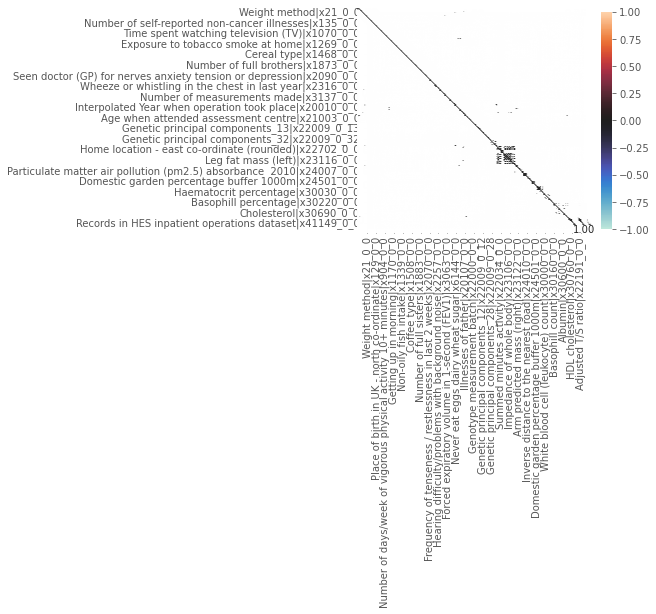

Time taken for correlations: 19.23661565463214 mins


In [20]:
# Runs the analysis producing a heatmap and matrix (heatmap too large)
s = timer()
corr_matrix = associations(df, nominal_columns=categorical_cols)
e = timer()
print(f'Time taken for correlations: {(e - s)/60} mins')

In [21]:
# Extract the matrix as heatmap is too large 
df_complete_corr=corr_matrix['corr']
df_complete_corr = df_complete_corr.dropna(axis=1, how='all').dropna(axis=0, how='all')

In [22]:
df_complete_corr

,Weight method|x21_0_0,Spirometry method|x23_0_0,Sex|x31_0_0,Year of birth|x34_0_0,Hand grip strength (left)|x46_0_0,Hand grip strength (right)|x47_0_0,Waist circumference|x48_0_0,Hip circumference|x49_0_0,Standing height|x50_0_0,Seated height|x51_0_0,...,Records in HES inpatient diagnoses dataset|x41234_0_0,Records in HES inpatient main dataset|x41259_0_0,Unadjusted T/S ratio|x22190_0_0,Adjusted T/S ratio|x22191_0_0,Z-adjusted T/S log|x22192_0_0,Creatinine (enzymatic) in urine|x30510_0_0,Potassium in urine|x30520_0_0,Sodium in urine|x30530_0_0,medication_cbi,thyroid_cancer
Weight method|x21_0_0,1.000000,0.031618,0.011952,0.012899,0.104570,0.111553,0.253236,0.399031,0.559119,0.525338,...,0.082098,0.054355,0.008448,0.008191,0.010949,0.017531,0.028530,0.016083,0.031202,0.000000
Spirometry method|x23_0_0,0.031618,1.000000,0.003744,0.010449,0.019220,0.020658,0.008911,0.015920,0.029972,0.045098,...,0.011875,0.008999,0.000436,0.000347,0.005967,0.002936,0.005469,0.010658,0.005596,0.004246
Sex|x31_0_0,0.011952,0.003744,1.000000,0.054019,0.694785,0.689697,0.427368,0.000599,0.484896,0.346421,...,0.031765,0.009868,0.058874,0.062645,0.097921,0.304725,0.130873,0.223641,0.150609,0.012683
Year of birth|x34_0_0,0.012899,0.010449,0.054019,1.000000,0.155098,0.154698,0.109826,0.030210,0.059051,0.070376,...,0.117822,0.080491,0.124242,0.127471,0.197080,0.071164,0.024530,0.109614,0.160075,0.001547
Hand grip strength (left)|x46_0_0,0.104570,0.019220,0.694785,0.155098,1.000000,0.890640,0.296933,0.063285,0.507303,0.398472,...,-0.062794,-0.055414,-0.013334,-0.015215,-0.020874,0.236863,0.105246,0.185698,0.040654,0.011315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Creatinine (enzymatic) in urine|x30510_0_0,0.017531,0.002936,0.304725,0.071164,0.236863,0.237905,0.266719,0.140749,0.188249,0.160200,...,0.013296,0.004292,-0.002414,-0.004544,-0.017257,1.000000,0.690171,0.477148,0.043463,0.001051
Potassium in urine|x30520_0_0,0.028530,0.005469,0.130873,0.024530,0.105246,0.106364,0.133192,0.087214,0.110266,0.110804,...,-0.015927,-0.016296,-0.002410,-0.003548,-0.012114,0.690171,1.000000,0.407987,0.029898,0.000342
Sodium in urine|x30530_0_0,0.016083,0.010658,0.223641,0.109614,0.185698,0.181476,0.226348,0.120400,0.105385,0.105679,...,-0.019024,-0.016714,0.007609,0.005780,-0.001587,0.477148,0.407987,1.000000,0.027979,0.001086
medication_cbi,0.031202,0.005596,0.150609,0.160075,0.040654,0.039842,0.270973,0.137511,0.037320,0.140667,...,0.171430,0.107038,0.063785,0.066087,0.086014,0.043463,0.029898,0.027979,1.000000,0.000000


In [23]:
# Write feature correlations to csv
df_complete_corr.to_csv('/data/home/bt211037/dissertation/feature_correlations.tsv', sep='\t')

In [24]:
# Find highly correlated features from matrix
def find_high_corr(df, filepath):
    
    dictionary = {}
    
    index = df.index.values
    
    for item in df.columns:
        
        col = list(df[item])
        
        for i, val in enumerate(col):
            
            if val > 0.9 and val <1:
                
                dictionary[item] = [index[i], val]
    
    dataframe = pd.DataFrame.from_dict(dictionary, orient='index', columns=['feature2', 'correlation'])
    dataframe.index.name = 'feature1'
    
    
    dataframe.to_csv(filepath, sep='\t')
    
    return dataframe
            
        
    

In [25]:
high_corr = find_high_corr(df_complete_corr, '/data/home/bt211037/dissertation/high_corr.tsv')

In [31]:
high_corr.head(51)

,feature2,correlation
feature1,,
Sex|x31_0_0,Genetic sex|x22001_0_0,0.999194
Seated height|x51_0_0,Sitting height|x20015_0_0,0.926260
UK Biobank assessment centre|x54_0_0,Distance (Euclidean) to coast|x24508_0_0,0.946231
Number of operations self-reported|x136_0_0,Interpolated Year when operation took place|x2...,0.978573
Past tobacco smoking|x1249_0_0,Ever smoked|x20160_0_0,0.989876
Forced vital capacity (FVC)|x3062_0_0,Forced expiratory volume in 1-second (FEV1)|x3...,0.960372
Forced expiratory volume in 1-second (FEV1)|x3063_0_0,Forced vital capacity (FVC)|x3062_0_0,0.960372
Seating box height|x3077_0_0,Seated height|x51_0_0,0.908161
Diastolic blood pressure automated reading|x4079_0_0,Systolic blood pressure automated reading|x408...,0.923422


In [34]:
high_corr.tail(50)

,feature2,correlation
feature1,,
Trunk fat percentage|x23127_0_0,Body fat percentage|x23099_0_0,0.950159
Trunk fat mass|x23128_0_0,Whole body fat mass|x23100_0_0,0.947580
Trunk fat-free mass|x23129_0_0,Trunk predicted mass|x23130_0_0,0.998818
Trunk predicted mass|x23130_0_0,Trunk fat-free mass|x23129_0_0,0.998818
Nitrogen dioxide air pollution 2010|x24003_0_0,Nitrogen oxides air pollution 2010|x24004_0_0,0.929200
Nitrogen oxides air pollution 2010|x24004_0_0,Nitrogen dioxide air pollution 2010|x24003_0_0,0.929200
Particulate matter air pollution (pm10) 2010|x24005_0_0,Particulate matter air pollution 2.5-10um 201...,0.966786
Particulate matter air pollution (pm2.5) 2010|x24006_0_0,Particulate matter air pollution (pm10) 2010|...,0.936768
Particulate matter air pollution 2.5-10um 2010|x24008_0_0,Particulate matter air pollution (pm10) 2010|...,0.966786


# Remove some highly correlated features

In [3]:
# Read in CSV
df = pd.read_csv('/data/home/bt211037/dissertation/supervised_ML_data.tsv', sep='\t', header=0, index_col = 0)

In [5]:
# List of features to remove
rem_features = ['Sex|x31_0_0', 'Seated height|x51_0_0', 'Ever smoked|x20160_0_0', 'Seating box height|x3077_0_0',
    'Home location - north co-ordinate (rounded)|x22704_0_0', 'Age at recruitment|x21022_0_0',
    'Average 16-hour sound level of noise pollution|x24023_0_0']

In [7]:
df.drop(rem_features, axis=1, inplace=True)

In [8]:
df

,Weight method|x21_0_0,Spirometry method|x23_0_0,Year of birth|x34_0_0,Hand grip strength (left)|x46_0_0,Hand grip strength (right)|x47_0_0,Waist circumference|x48_0_0,Hip circumference|x49_0_0,Standing height|x50_0_0,Month of birth|x52_0_0,UK Biobank assessment centre|x54_0_0,...,Records in HES inpatient diagnoses dataset|x41234_0_0,Records in HES inpatient main dataset|x41259_0_0,Unadjusted T/S ratio|x22190_0_0,Adjusted T/S ratio|x22191_0_0,Z-adjusted T/S log|x22192_0_0,Creatinine (enzymatic) in urine|x30510_0_0,Potassium in urine|x30520_0_0,Sodium in urine|x30530_0_0,medication_cbi,thyroid_cancer
userId,,,,,,,,,,,,,,,,,,,,,
1000020,1.0,0.0,1959,20.0,22.0,73.0,96.0,163.0,2,2,...,8.0,4.0,0.655945,0.679486,-1.234300,5946.0,29.5,62.5,-1.0,0.0
1000037,1.0,0.0,1945,10.0,16.0,91.0,105.0,154.0,5,11,...,1.0,1.0,0.781721,0.831970,0.076134,13411.0,61.9,46.6,-1.0,0.0
1000043,1.0,0.0,1960,20.0,22.0,87.0,110.0,166.0,3,20,...,16.0,8.0,0.549019,0.622271,-1.803630,17128.0,77.4,85.4,-1.0,0.0
1000066,1.0,0.0,1943,30.0,33.0,92.0,104.0,176.0,7,7,...,1.0,1.0,0.669092,0.771750,-0.410190,8338.0,84.1,60.8,-1.0,0.0
1000092,1.0,0.0,1957,12.0,18.0,83.0,118.0,160.0,2,18,...,7.0,4.0,0.821316,0.903952,0.613230,9397.0,113.5,73.9,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6025060,1.0,0.0,1947,42.0,32.0,113.0,113.0,174.0,12,16,...,1.0,1.0,0.714065,0.773410,-0.396277,13430.0,97.3,143.7,2.0,0.0
6025078,1.0,0.0,1952,40.0,40.0,85.0,103.0,175.0,10,4,...,2.0,2.0,0.677468,0.800857,-0.170562,12910.0,63.2,139.9,-1.0,0.0
6025087,1.0,NaN,1942,34.0,34.0,107.0,109.0,169.0,3,22,...,2.0,1.0,0.546040,0.620449,-1.822620,25218.0,84.1,130.6,2.0,0.0


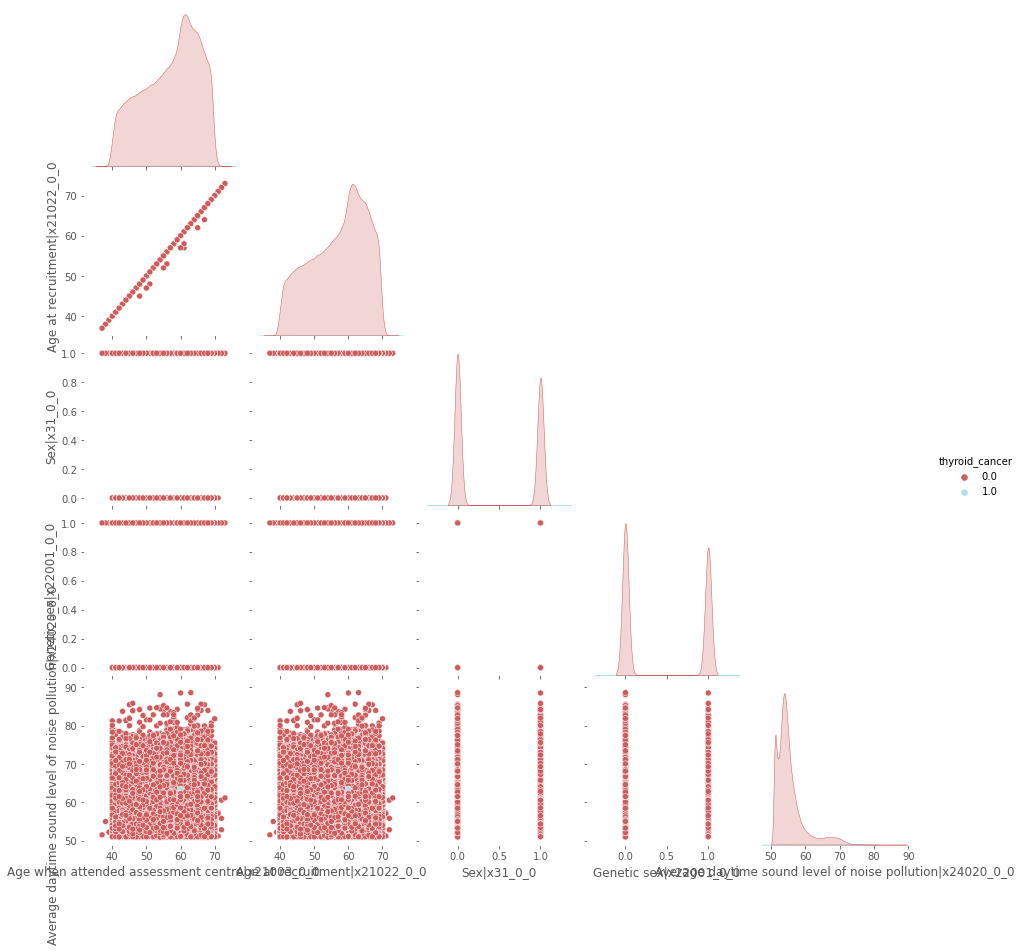

In [30]:
# Pairplot to look at correlated values - batched in smaller groups

customPalette = sns.set_palette(sns.color_palette(colours))

data = high_corr[0:5]
data.append('thyroid_cancer')

sns.pairplot(df[data], hue="thyroid_cancer", corner=True, palette=customPalette)

plt.show()


# Look at categorical data 

Will labal encoding or categorical encoding be needed and for which columns.

In [31]:
# Look at categorical clumns to see which should be one hot encoded and which label encoded
categorical_cols

['Weight method|x21_0_0',
 'Spirometry method|x23_0_0',
 'Sex|x31_0_0',
 'Year of birth|x34_0_0',
 'Month of birth|x52_0_0',
 'UK Biobank assessment centre|x54_0_0',
 'Month of attending assessment centre|x55_0_0',
 'Birth weight known|x120_0_0',
 'Number of self-reported cancers|x134_0_0',
 'Number of self-reported non-cancer illnesses|x135_0_0',
 'Number of operations self-reported|x136_0_0',
 'Number of treatments/medications taken|x137_0_0',
 'Type of accommodation lived in|x670_0_0',
 'Own or rent accommodation lived in|x680_0_0',
 'Number in household|x709_0_0',
 'Number of vehicles in household|x728_0_0',
 'Average total household income before tax|x738_0_0',
 'Number of days/week walked 10+ minutes|x864_0_0',
 'Number of days/week of moderate physical activity 10+ minutes|x884_0_0',
 'Number of days/week of vigorous physical activity 10+ minutes|x904_0_0',
 'Usual walking pace|x924_0_0',
 'Frequency of stair climbing in last 4 weeks|x943_0_0',
 'Frequency of friend/family visit

In [12]:
one_hot = ['Weight method|x21_0_0', 'Spirometry method|x23_0_0', 'Sex|x31_0_0', 
           'UK Biobank assessment centre|x54_0_0', 'Birth weight known|x120_0_0', 
           'Type of accommodation lived in|x670_0_0',
           'Own or rent accommodation lived in|x680_0_0', 'Drive faster than motorway speed limit|x1100_0_0',
           'Usual side of head for mobile phone use|x1150_0_0', 'Usual side of head for mobile phone use|x1150_0_0',
           'Morning/evening person (chronotype)|x1180_0_0', 'Nap during day|x1190_0_0', 'Snoring|x1210_0_0',
           'Daytime dozing / sleeping (narcolepsy)|x1220_0_0', 'Current tobacco smoking|x1239_0_0',
           'Past tobacco smoking|x1249_0_0', 'Major dietary changes in the last 5 years|x1538_0_0',
           'Variation in diet|x1548_0_0',  'Alcohol usually taken with meals|x1618_0_0',
           'Alcohol intake versus 10 years previously|x1628_0_0', 'Skin colour|x1717_0_0', 
           'Ease of skin tanning|x1727_0_0', 'Hair colour (natural before greying)|x1747_0_0',
           'Facial ageing|x1757_0_0', 'Father still alive|x1797_0_0', 'Mother still alive|x1835_0_0', 
           'Mood swings|x1920_0_0', 'Miserableness|x1930_0_0', 'Irritability|x1940_0_0', 
           'Sensitivity / hurt feelings|x1950_0_0', 'Fed-up feelings|x1960_0_0', 'Nervous feelings|x1970_0_0',
           'Worrier / anxious feelings|x1980_0_0', "Tense / 'highly strung'|x1990_0_0",
           'Worry too long after embarrassment|x2000_0_0', "Suffer from 'nerves'|x2010_0_0",
           'Loneliness isolation|x2020_0_0', 'Guilty feelings|x2030_0_0', 'Risk taking|x2040_0_0',
           'Seen doctor (GP) for nerves anxiety tension or depression|x2090_0_0',
           'Seen a psychiatrist for nerves anxiety tension or depression|x2100_0_0',
           'Able to confide|x2110_0_0',
           'Answered sexual history questions|x2129_0_0',
           'Ever had same-sex intercourse|x2159_0_0', 'Long-standing illness disability or infirmity|x2188_0_0',
           'Wears glasses or contact lenses|x2207_0_0', 'Other eye problems|x2227_0_0',
           'Plays computer games|x2237_0_0', 'Hearing difficulty/problems|x2247_0_0',
           'Hearing difficulty/problems with background noise|x2257_0_0', 'Use of sun/uv protection|x2267_0_0',
           'Weight change compared with 1 year ago|x2306_0_0',
           'Wheeze or whistling in the chest in last year|x2316_0_0',
           'Chest pain or discomfort|x2335_0_0',
           'Ever had bowel cancer screening|x2345_0_0',
           'Diabetes diagnosed by doctor|x2443_0_0',
           'Cancer diagnosed by doctor|x2453_0_0',
           'Fractured/broken bones in last 5 years|x2463_0_0',
           'Other serious medical condition/disability diagnosed by doctor|x2473_0_0',
           'Taking other prescription medications|x2492_0_0',
           'Pace-maker|x3079_0_0', 'Contra-indications for spirometry|x3088_0_0', 
           'Caffeine drink within last hour|x3089_0_0', 'Used an inhaler for chest within last hour|x3090_0_0',
           'Method of measuring blood pressure|x4081_0_0', 'Qualifications|x6138_0_0',
           'Gas or solid-fuel cooking/heating|x6139_0_0', 
           'How are people in household related to participant|x6141_0_0',
           'Current employment status|x6142_0_0',
           'Never eat eggs dairy wheat sugar|x6144_0_0',
           'Illness injury bereavement stress in last 2 years|x6145_0_0',
           'Attendance/disability/mobility allowance|x6146_0_0',
           'Mouth/teeth dental problems|x6149_0_0',
           'Medication for pain relief constipation heartburn|x6154_0_0',
           'Vitamin and mineral supplements|x6155_0_0', 'Pain type(s) experienced in last month|x6159_0_0',
           'Leisure/social activities|x6160_0_0',
           'Types of transport used (excluding work)|x6162_0_0',
           'Types of physical activity in last 4 weeks|x6164_0_0',
           'Mineral and other dietary supplements|x6179_0_0',
           'Illnesses of father|x20107_0_0',
           'Illnesses of mother|x20110_0_0',
           'Illnesses of siblings|x20111_0_0',
           'Smoking status|x20116_0_0',
           'Alcohol drinker status|x20117_0_0',
           'Home area population density - urban or rural|x20118_0_0',
           'Ever smoked|x20160_0_0',  'Spirometry QC measure|x20255_0_0', 'Genetic sex|x22001_0_0',
           'Genetic kinship to other participants|x22021_0_0',
           'IPAQ activity group|x22032_0_0', 'Summed days activity|x22033_0_0',
           'Above moderate/vigorous recommendation|x22035_0_0',
           'Above moderate/vigorous/walking recommendation|x22036_0_0',
           'Close to major road|x24014_0_0', 'medication_cbi' ]

In [13]:
label = ['Year of birth|x34_0_0', 'Month of birth|x52_0_0', 'Month of attending assessment centre|x55_0_0', 
         'Number of self-reported cancers|x134_0_0', 'Number of self-reported non-cancer illnesses|x135_0_0',
         'Number of operations self-reported|x136_0_0', 'Number of treatments/medications taken|x137_0_0',
         'Number in household|x709_0_0',  'Number of vehicles in household|x728_0_0', 
         'Average total household income before tax|x738_0_0',
         'Number of days/week walked 10+ minutes|x864_0_0', 
         'Number of days/week of moderate physical activity 10+ minutes|x884_0_0',
         'Number of days/week of vigorous physical activity 10+ minutes|x904_0_0', 'Usual walking pace|x924_0_0',
         'Frequency of stair climbing in last 4 weeks|x943_0_0', 'Frequency of friend/family visits|x1031_0_0',
         'Time spend outdoors in summer|x1050_0_0', 'Time spent outdoors in winter|x1060_0_0', 
         'Time spent watching television (TV)|x1070_0_0','Time spent using computer|x1080_0_0', 
         'Time spent driving|x1090_0_0', 'Length of mobile phone use|x1110_0_0',
         'Weekly usage of mobile phone in last 3 months|x1120_0_0',
         'Hands-free device/speakerphone use with mobile phone in last 3 month|x1130_0_0',
         'Difference in mobile phone use compared to two years previously|x1140_0_0', 'Sleep duration|x1160_0_0',
         'Getting up in morning|x1170_0_0', 'Sleeplessness / insomnia|x1200_0_0', 
         'Smoking/smokers in household|x1259_0_0', 'Cooked vegetable intake|x1289_0_0',
         'Salad / raw vegetable intake|x1299_0_0', 'Fresh fruit intake|x1309_0_0', 'Dried fruit intake|x1319_0_0',
         'Oily fish intake|x1329_0_0', 'Non-oily fish intake|x1339_0_0', 'Processed meat intake|x1349_0_0',
         'Poultry intake|x1359_0_0', 'Beef intake|x1369_0_0', 'Lamb/mutton intake|x1379_0_0',
         'Pork intake|x1389_0_0', 'Cheese intake|x1408_0_0', 'Milk type used|x1418_0_0',
         'Spread type|x1428_0_0', 'Bread type|x1448_0_0', 'Cereal intake|x1458_0_0',
         'Cereal type|x1468_0_0', 'Salt added to food|x1478_0_0', 'Coffee intake|x1498_0_0',
         'Coffee type|x1508_0_0', 'Hot drink temperature|x1518_0_0', 'Water intake|x1528_0_0',
         'Alcohol intake frequency.|x1558_0_0', 'Number of full brothers|x1873_0_0',
         'Number of full sisters|x1883_0_0', 'Frequency of depressed mood in last 2 weeks|x2050_0_0',
         'Frequency of unenthusiasm / disinterest in last 2 weeks|x2060_0_0',
         'Frequency of tenseness / restlessness in last 2 weeks|x2070_0_0',
         'Frequency of tiredness / lethargy in last 2 weeks|x2080_0_0', 'Overall health rating|x2178_0_0'
         'Falls in the last year|x2296_0_0', 'Result ranking|x3059_0_0',
         'Ordering of blows|x3065_0_0',  'Seating box height|x3077_0_0', 'Number of measurements made|x3137_0_0',
         'Neuroticism score|x20127_0_0', 'Age when attended assessment centre|x21003_0_0',
         'Age at recruitment|x21022_0_0', 'Genotype measurement batch|x22000_0_0',
         'Total volume of urine samples held by UKB|x30394_0_0']

In [15]:
# Remove columns in rem_features
one_hot = [x for x in one_hot if x not in rem_features]
label = [x for x in label if x not in rem_features]

In [16]:
print(one_hot)

['Weight method|x21_0_0', 'Spirometry method|x23_0_0', 'UK Biobank assessment centre|x54_0_0', 'Birth weight known|x120_0_0', 'Type of accommodation lived in|x670_0_0', 'Own or rent accommodation lived in|x680_0_0', 'Drive faster than motorway speed limit|x1100_0_0', 'Usual side of head for mobile phone use|x1150_0_0', 'Usual side of head for mobile phone use|x1150_0_0', 'Morning/evening person (chronotype)|x1180_0_0', 'Nap during day|x1190_0_0', 'Snoring|x1210_0_0', 'Daytime dozing / sleeping (narcolepsy)|x1220_0_0', 'Current tobacco smoking|x1239_0_0', 'Past tobacco smoking|x1249_0_0', 'Major dietary changes in the last 5 years|x1538_0_0', 'Variation in diet|x1548_0_0', 'Alcohol usually taken with meals|x1618_0_0', 'Alcohol intake versus 10 years previously|x1628_0_0', 'Skin colour|x1717_0_0', 'Ease of skin tanning|x1727_0_0', 'Hair colour (natural before greying)|x1747_0_0', 'Facial ageing|x1757_0_0', 'Father still alive|x1797_0_0', 'Mother still alive|x1835_0_0', 'Mood swings|x1920

In [17]:
print(label)

['Year of birth|x34_0_0', 'Month of birth|x52_0_0', 'Month of attending assessment centre|x55_0_0', 'Number of self-reported cancers|x134_0_0', 'Number of self-reported non-cancer illnesses|x135_0_0', 'Number of operations self-reported|x136_0_0', 'Number of treatments/medications taken|x137_0_0', 'Number in household|x709_0_0', 'Number of vehicles in household|x728_0_0', 'Average total household income before tax|x738_0_0', 'Number of days/week walked 10+ minutes|x864_0_0', 'Number of days/week of moderate physical activity 10+ minutes|x884_0_0', 'Number of days/week of vigorous physical activity 10+ minutes|x904_0_0', 'Usual walking pace|x924_0_0', 'Frequency of stair climbing in last 4 weeks|x943_0_0', 'Frequency of friend/family visits|x1031_0_0', 'Time spend outdoors in summer|x1050_0_0', 'Time spent outdoors in winter|x1060_0_0', 'Time spent watching television (TV)|x1070_0_0', 'Time spent using computer|x1080_0_0', 'Time spent driving|x1090_0_0', 'Length of mobile phone use|x111

# Save data
- Headers have been changed from phecodes to descriptions
- Some highly correlated features have been removed (manual inspection)

In [9]:
# Save dataframe with new headers for downstream analsysis
df.to_csv('/data/home/bt211037/dissertation/supervised_ML_data.tsv', sep='\t')